# Stock price outlier indentification
Using pyspark to clean a stock price dataset and remove any outliers

## Imports

In [6]:
# import necessary libraries
import pandas as pd 
import numpy
import matplotlib.pyplot as plt 
import os
import sys
from pyspark.sql import SparkSession

# create sparksession
spark = SparkSession \
    .builder \
    .appName("Pysparkexample") \
    .getOrCreate()

## Reading in Outliers.csv i.e. raw, uncleaned data set

In [57]:
fpath = os.path.join(sys.path[0], "..", "data", "Outliers.csv")
df = spark.read.csv(fpath, header=True)
df.head(10)

[Row(Date='09/12/2017', Price='229.4'),
 Row(Date='10/12/2017', Price='229.4'),
 Row(Date='11/12/2017', Price='230.5'),
 Row(Date='12/12/2017', Price='400.1'),
 Row(Date='13/12/2017', Price='230.9'),
 Row(Date='14/12/2017', Price='229.7'),
 Row(Date='15/12/2017', Price='230'),
 Row(Date='16/12/2017', Price='230'),
 Row(Date='17/12/2017', Price='230'),
 Row(Date='18/12/2017', Price='231.35')]

## Changing column data types

In [58]:
df.dtypes

[('Date', 'string'), ('Price', 'string')]

In [62]:
from pyspark.sql import functions as f
df = df.withColumn('Date', f.to_date(f.col('Date'), 'dd/MM/yyyy'))
df = df.withColumn('Price', f.col('Price').cast('double'))
df.head()

Row(Date=datetime.date(2017, 12, 9), Price=229.4)

## Plotting to get an initial data idea

In [82]:
df = df.sort("Date")

In [88]:
df_pandas = df.toPandas()
df_pandas["Date"] = pd.to_datetime(df_pandas["Date"])

<AxesSubplot:xlabel='Date'>

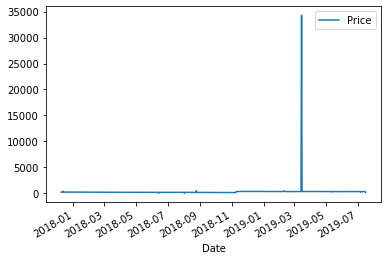

In [91]:
df_pandas.plot("Date", "Price")

## Algorithm to remove outliers
Check percentage difference to previous point. If greater than a set threshold, remove

In [127]:
from pyspark.sql import Window
window_spec = Window.orderBy('Date')
df = df.withColumn('prev_price', f.lag('Price').over(window_spec))
df = df.withColumn('pcnt_diff', (100*(f.col('Price') - f.col('prev_price'))/(f.col('prev_price'))))

In [128]:
df.take(10)

21/10/24 14:04:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/10/24 14:04:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/10/24 14:04:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


[Row(Date=datetime.date(2017, 12, 9), Price=229.4, prev_price=None, pcnt_diff=None),
 Row(Date=datetime.date(2017, 12, 10), Price=229.4, prev_price=229.4, pcnt_diff=0.0),
 Row(Date=datetime.date(2017, 12, 11), Price=230.5, prev_price=229.4, pcnt_diff=0.479511769834348),
 Row(Date=datetime.date(2017, 12, 12), Price=400.1, prev_price=230.5, pcnt_diff=73.57917570498917),
 Row(Date=datetime.date(2017, 12, 13), Price=230.9, prev_price=400.1, pcnt_diff=-42.289427643089226),
 Row(Date=datetime.date(2017, 12, 14), Price=229.7, prev_price=230.9, pcnt_diff=-0.5197055002165514),
 Row(Date=datetime.date(2017, 12, 15), Price=230.0, prev_price=229.7, pcnt_diff=0.13060513713539895),
 Row(Date=datetime.date(2017, 12, 16), Price=230.0, prev_price=230.0, pcnt_diff=0.0),
 Row(Date=datetime.date(2017, 12, 17), Price=230.0, prev_price=230.0, pcnt_diff=0.0),
 Row(Date=datetime.date(2017, 12, 18), Price=231.35, prev_price=230.0, pcnt_diff=0.5869565217391279)]